<a href="https://colab.research.google.com/github/bakircikagan/is_detectron2_lvis/blob/main/Instance_Segmentation_with_LVIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

Check gpu availability

In [1]:
import torch
torch.cuda.is_available()

True

Download lvis v1 train data and respective json file metadata

In [2]:
# Download the training set
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip > /dev/null
!rm train2017.zip

!wget https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_train.json.zip
!unzip lvis_v1_train.json.zip > /dev/null
!rm lvis_v1_train.json.zip

--2022-06-04 12:39:11--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.46.36
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.46.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  34.1MB/s    in 9m 26s  

2022-06-04 12:48:38 (32.6 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-06-04 12:51:13--  https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_train.json.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.169.208
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.169.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350264821 (334M) [application/zip]
Saving to: ‘lvis_v1_train.json.zip’

lvis_v1_train.json. 100%[===================>] 334

Download lvis v1 validation data and respective json file metadata

In [3]:
# Download the validation set
!wget https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_val.json.zip
!unzip lvis_v1_val.json.zip > /dev/null 
!rm lvis_v1_val.json.zip

!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip > /dev/null 
!rm val2017.zip


--2022-06-04 12:51:43--  https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_val.json.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.177.200
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.177.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64026968 (61M) [application/zip]
Saving to: ‘lvis_v1_val.json.zip’

lvis_v1_val.json.zi 100%[===================>]  61.06M  16.5MB/s    in 4.7s    

2022-06-04 12:51:49 (13.0 MB/s) - ‘lvis_v1_val.json.zip’ saved [64026968/64026968]

--2022-06-04 12:51:51--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.171.193
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.171.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  33

Install dependencies: pyyaml, detectron2, lvis-api

In [4]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!python -m pip install 'git+https://github.com/lvis-dataset/lvis-api.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 14.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=98b7685f4fbc69d44b8f3a6fdc18ad58bed8d303ab6b4d910a9c3d78f9fae3f3
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-kix9wj6m
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-kix9wj6m
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 79 kB

Import statements

In [2]:
import torch
import detectron2
import cv2
import numpy as np
import os 
import json
import random
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets.lvis import  register_lvis_instances
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, SemSegEvaluator, LVISEvaluator
from detectron2.data import build_detection_test_loader


from google.colab.patches import cv2_imshow

# Helper Functions and display sample data

Helper functions

In [8]:
# Takes json file and image folder paths, returns list of dictionaries in coco format
# according to https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html
# Filters LVIS data to only consider 'ski_pole' and 'belt' categories 
def get_dataset_dict(json_file: str, image_folder: str) -> list:
  SKI_POLE_ID = -1
  BELT_ID = -1
  with open(json_file, 'r') as f:
      lvis = json.load(f)

  filtered_categories = list(filter(lambda cat: cat['name'] == 'belt' 
                                  or  cat['name'] == 'ski_pole', lvis['categories']))
  for cat in filtered_categories:
    name = cat['name']
    id = cat['id']
    if name == 'belt':
      BELT_ID = id
    elif name == 'ski_pole':
      SKI_POLE_ID = id

  filtered_annotations =  list(filter(lambda annot: 
                              annot['category_id'] == SKI_POLE_ID or 
                              annot['category_id'] == BELT_ID, lvis['annotations']))


  dataset_dicts = []

  for image in lvis['images']:
    image_id = image['id']
    file_name = image['coco_url'][-16:]
    file_name = image_folder + '/' + file_name
    if os.path.exists(file_name):
      record = {}
      record['image_id'] = image_id 
      record['file_name'] = file_name
      record['height'] = image['height']
      record['width'] = image['width']

      found_annotations = list(filter(lambda x: x['image_id'] == image['id'], filtered_annotations))
      res_annotations = []
      for annot in found_annotations:
        new_annot = {}
        new_annot['bbox'] = annot['bbox']
        new_annot['category_id'] = 0 if annot['category_id'] == BELT_ID else 1
        new_annot['bbox_mode'] = BoxMode.XYWH_ABS
        new_annot['segmentation'] = annot['segmentation']
        res_annotations.append(new_annot)
      
      record['annotations'] = res_annotations
      if len(found_annotations) > 0:
        dataset_dicts.append(record)

  return dataset_dicts

# Does the training once datasets are registered
# Return config and predictor for evaluation purposes
def train(model_yaml: str, max_iterations):
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file(model_yaml))

  cfg.DATASETS.TRAIN = ('belt_pole_train',)
  cfg.DATASETS.TEST = ('belt_pole_val', )

  cfg.DATALOADER.NUM_WORKERS = 2
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml)
  cfg.SOLVER.IMS_PER_BATCH = 4
  cfg.SOLVER.BASE_LR = 0.001
  cfg.SOLVER.MAX_ITER = max_iterations
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  #only two classes 
  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


  trainer = DefaultTrainer(cfg)
  trainer.resume_or_load(resume=False)
  trainer.train()

  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
  predictor = DefaultPredictor(cfg)

  return cfg, predictor

Preparing and registering the datasets

In [4]:
train_dataset_dicts = get_dataset_dict('lvis_v1_train.json', 'train2017')
val_dataset_dicts = get_dataset_dict('lvis_v1_val.json', 'val2017')

In [5]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ['train',]:
  DatasetCatalog.register('belt_pole_' + d, lambda d=d: train_dataset_dicts)
  MetadataCatalog.get('belt_pole_' + d).set(thing_classes=['belt', 'ski_pole'])

for d in ['val']:
  DatasetCatalog.register('belt_pole_' + d, lambda d=d: val_dataset_dicts)
  MetadataCatalog.get('belt_pole_' + d).set(thing_classes=['belt', 'ski_pole'])

train_metadata = MetadataCatalog.get("belt_pole_train")


Visualize samples from the training dataset

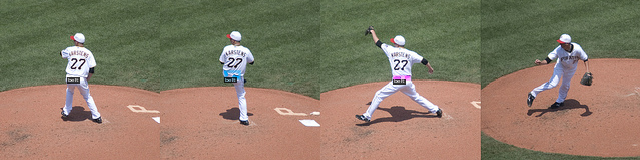

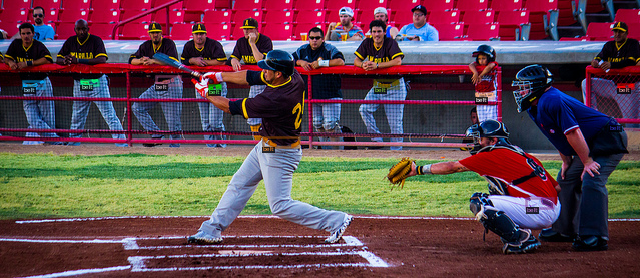

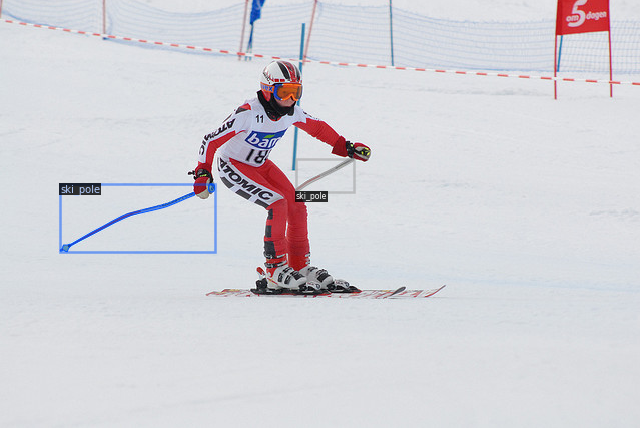

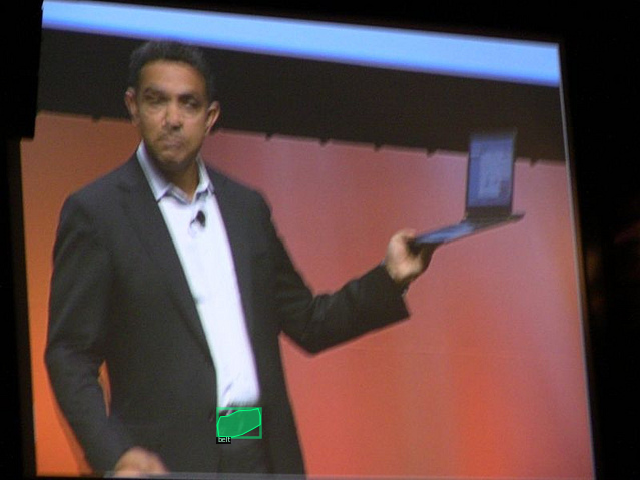

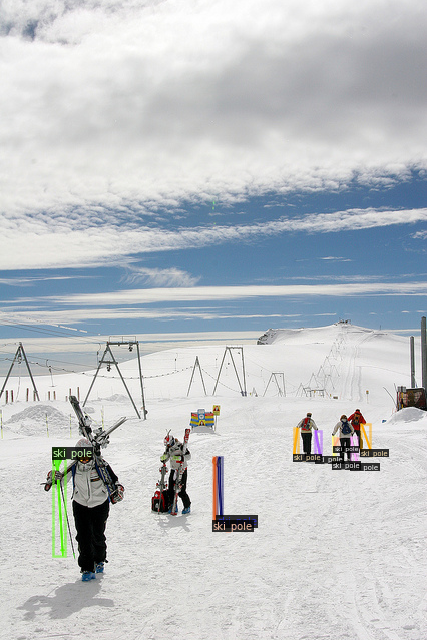

In [6]:
for d in random.sample(train_dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Training the models

We use 4 different models from detectron2 model zoo to train our data. 3 of the models are LVIS models considering that our validation data and our test data(val) are both from LVIS dataset. Although these models trained with LVISv0.5 and our datasets are LVISv1.0, we expect them to achieve the highest score nevertheless. 

Our last model is COCO Instance segmentation, which we expect to perform worse and we will use its results as sanity check.

https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md 

In [7]:
model_yaml_1 = 'LVISv0.5-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml'
cfg_1, predictor_1 = train(model_yaml_1, 400)

[06/04 13:12:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (1231, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (1231,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4920, 1024) 

[06/04 13:12:29 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/04 13:13:34 d2.utils.events]:  eta: 0:20:52  iter: 19  total_loss: 2.153  loss_cls: 0.9181  loss_box_reg: 0.4504  loss_mask: 0.6367  loss_rpn_cls: 0.04801  loss_rpn_loc: 0.07045  time: 3.1861  data_time: 0.0881  lr: 4.8453e-05  max_mem: 11283M
[06/04 13:14:38 d2.utils.events]:  eta: 0:19:39  iter: 39  total_loss: 1.452  loss_cls: 0.496  loss_box_reg: 0.4649  loss_mask: 0.3006  loss_rpn_cls: 0.05387  loss_rpn_loc: 0.03705  time: 3.1917  data_time: 0.0257  lr: 9.8403e-05  max_mem: 11283M
[06/04 13:15:38 d2.utils.events]:  eta: 0:18:11  iter: 59  total_loss: 1.376  loss_cls: 0.3799  loss_box_reg: 0.5251  loss_mask: 0.2487  loss_rpn_cls: 0.06063  loss_rpn_loc: 0.1026  time: 3.1248  data_time: 0.0227  lr: 0.00014835  max_mem: 11283M
[06/04 13:16:43 d2.utils.events]:  eta: 0:17:16  iter: 79  total_loss: 1.136  loss_cls: 0.249  loss_box_reg: 0.4818  loss_mask: 0.2336  loss_rpn_cls: 0.05711  loss_rpn_loc: 0.1057  time: 3.1587  data_time: 0.0236  lr: 0.0001983  max_mem: 11283M
[06/04 13:17:

In [10]:
model_yaml_2 = 'LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml'
cfg_2, predictor_2 = train(model_yaml_2, 400)

[06/04 13:35:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_571f7c.pkl: 203MB [00:11, 17.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (1231, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (1231,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4920, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4920,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model du

[06/04 13:36:08 d2.engine.train_loop]: Starting training from iteration 0
[06/04 13:36:29 d2.utils.events]:  eta: 0:06:26  iter: 19  total_loss: 2.186  loss_cls: 0.9773  loss_box_reg: 0.4388  loss_mask: 0.6349  loss_rpn_cls: 0.06324  loss_rpn_loc: 0.05492  time: 1.0268  data_time: 0.0542  lr: 4.8453e-05  max_mem: 11283M
[06/04 13:36:51 d2.utils.events]:  eta: 0:06:13  iter: 39  total_loss: 1.397  loss_cls: 0.5159  loss_box_reg: 0.3663  loss_mask: 0.3531  loss_rpn_cls: 0.06386  loss_rpn_loc: 0.05411  time: 1.0578  data_time: 0.0431  lr: 9.8403e-05  max_mem: 11283M
[06/04 13:37:12 d2.utils.events]:  eta: 0:05:54  iter: 59  total_loss: 1.122  loss_cls: 0.3609  loss_box_reg: 0.4059  loss_mask: 0.2254  loss_rpn_cls: 0.07756  loss_rpn_loc: 0.05996  time: 1.0579  data_time: 0.0430  lr: 0.00014835  max_mem: 11283M
[06/04 13:37:32 d2.utils.events]:  eta: 0:05:30  iter: 79  total_loss: 1.089  loss_cls: 0.2392  loss_box_reg: 0.4311  loss_mask: 0.2055  loss_rpn_cls: 0.06663  loss_rpn_loc: 0.06647 

In [11]:
model_yaml_3 = 'LVISv0.5-InstanceSegmentation/mask_rcnn_R_101_FPN_1x.yaml'
cfg_3, predictor_3 = train(model_yaml_2, 400)

[06/04 13:43:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (1231, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (1231,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4920, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4920,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (1230, 256, 1, 1) in the checkpoint but (2, 256, 

[06/04 13:43:21 d2.engine.train_loop]: Starting training from iteration 0
[06/04 13:43:43 d2.utils.events]:  eta: 0:06:37  iter: 19  total_loss: 2.345  loss_cls: 1.124  loss_box_reg: 0.3904  loss_mask: 0.613  loss_rpn_cls: 0.07981  loss_rpn_loc: 0.08268  time: 1.0525  data_time: 0.0555  lr: 4.8453e-05  max_mem: 11283M
[06/04 13:44:03 d2.utils.events]:  eta: 0:06:25  iter: 39  total_loss: 1.421  loss_cls: 0.4948  loss_box_reg: 0.4017  loss_mask: 0.352  loss_rpn_cls: 0.06548  loss_rpn_loc: 0.08059  time: 1.0452  data_time: 0.0410  lr: 9.8403e-05  max_mem: 11283M
[06/04 13:44:24 d2.utils.events]:  eta: 0:05:59  iter: 59  total_loss: 1.179  loss_cls: 0.3679  loss_box_reg: 0.427  loss_mask: 0.267  loss_rpn_cls: 0.06162  loss_rpn_loc: 0.0589  time: 1.0410  data_time: 0.0327  lr: 0.00014835  max_mem: 11283M
[06/04 13:44:46 d2.utils.events]:  eta: 0:05:44  iter: 79  total_loss: 1.047  loss_cls: 0.2729  loss_box_reg: 0.4007  loss_mask: 0.2322  loss_rpn_cls: 0.07212  loss_rpn_loc: 0.0547  time: 

In [12]:
model_yaml_4 = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg_4, predictor_4 = train(model_yaml_4, 400)

[06/04 13:50:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:15, 11.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[06/04 13:50:39 d2.engine.train_loop]: Starting training from iteration 0
[06/04 13:50:59 d2.utils.events]:  eta: 0:06:15  iter: 19  total_loss: 2.55  loss_cls: 1.108  loss_box_reg: 0.1265  loss_mask: 0.6887  loss_rpn_cls: 0.5015  loss_rpn_loc: 0.1917  time: 1.0029  data_time: 0.0545  lr: 4.8453e-05  max_mem: 11283M
[06/04 13:51:20 d2.utils.events]:  eta: 0:06:06  iter: 39  total_loss: 1.733  loss_cls: 0.5892  loss_box_reg: 0.1756  loss_mask: 0.6071  loss_rpn_cls: 0.2161  loss_rpn_loc: 0.1215  time: 1.0113  data_time: 0.0363  lr: 9.8403e-05  max_mem: 11283M
[06/04 13:51:41 d2.utils.events]:  eta: 0:05:48  iter: 59  total_loss: 1.484  loss_cls: 0.3625  loss_box_reg: 0.2595  loss_mask: 0.4935  loss_rpn_cls: 0.1226  loss_rpn_loc: 0.1607  time: 1.0195  data_time: 0.0392  lr: 0.00014835  max_mem: 11283M
[06/04 13:52:01 d2.utils.events]:  eta: 0:05:30  iter: 79  total_loss: 1.275  loss_cls: 0.3595  loss_box_reg: 0.2933  loss_mask: 0.3527  loss_rpn_cls: 0.09517  loss_rpn_loc: 0.09488  time: 1

# Evaluating the Results

We use COCOEvaluator to evaluate the average precision of our predictors. We observe that LVISEvaluator outputs a more detailed evaluation. However, this evaluator is not compatible with our registered dataset, due to the fact that we cocofied our lvis data in *get_dataset_dict* function to filter out the unncessary categories. This, however, is an implementation mistake that could not be corrected due to limited GPU time on Google colab. Nevertheless, COCOEvaluator is reliable to compare the prediction scores between the 4 different models.

https://detectron2.readthedocs.io/en/latest/modules/evaluation.html

In [37]:
evaluator = COCOEvaluator("belt_pole_val", output_dir="./output")

In [38]:
val_loader_1 = build_detection_test_loader(cfg_1, "belt_pole_val")
print(inference_on_dataset(predictor_1.model, val_loader_1, evaluator))

[06/04 14:43:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/04 14:43:09 d2.data.common]: Serializing 178 elements to byte tensors and concatenating them all ...
[06/04 14:43:09 d2.data.common]: Serialized dataset takes 0.24 MiB
[06/04 14:43:09 d2.evaluation.evaluator]: Start inference on 178 batches


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[06/04 14:43:13 d2.evaluation.evaluator]: Inference done 11/178. Dataloading: 0.0013 s/iter. Inference: 0.2856 s/iter. Eval: 0.0025 s/iter. Total: 0.2894 s/iter. ETA=0:00:48
[06/04 14:43:19 d2.evaluation.evaluator]: Inference done 30/178. Dataloading: 0.0025 s/iter. Inference: 0.2716 s/iter. Eval: 0.0035 s/iter. Total: 0.2778 s/iter. ETA=0:00:41
[06/04 14:43:24 d2.evaluation.evaluator]: Inference done 48/178. Dataloading: 0.0030 s/iter. Inference: 0.2710 s/iter. Eval: 0.0047 s/iter. Total: 0.2792 s/iter. ETA=0:00:36
[06/04 14:43:29 d2.evaluation.evaluator]: Inference done 65/178. Dataloading: 0.0032 s/iter. Inference: 0.2761 s/iter. Eval: 0.0042 s/iter. Total: 0.2840 s/iter. ETA=0:00:32
[06/04 14:43:34 d2.evaluation.evaluator]: Inference done 82/178. Dataloading: 0.0034 s/iter. Inference: 0.2789 s/iter. Eval: 0.0041 s/iter. Total: 0.2869 s/iter. ETA=0:00:27
[06/04 14:43:39 d2.evaluation.evaluator]: Inference done 100/178. Dataloading: 0.0036 s/iter. Inference: 0.2790 s/iter. Eval: 0.00

In [39]:
val_loader_2 = build_detection_test_loader(cfg_2, "belt_pole_val")
print(inference_on_dataset(predictor_2.model, val_loader_2, evaluator))

[06/04 14:44:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/04 14:44:03 d2.data.common]: Serializing 178 elements to byte tensors and concatenating them all ...
[06/04 14:44:03 d2.data.common]: Serialized dataset takes 0.24 MiB
[06/04 14:44:03 d2.evaluation.evaluator]: Start inference on 178 batches
[06/04 14:44:05 d2.evaluation.evaluator]: Inference done 14/178. Dataloading: 0.0016 s/iter. Inference: 0.1093 s/iter. Eval: 0.0035 s/iter. Total: 0.1144 s/iter. ETA=0:00:18
[06/04 14:44:10 d2.evaluation.evaluator]: Inference done 61/178. Dataloading: 0.0020 s/iter. Inference: 0.1047 s/iter. Eval: 0.0027 s/iter. Total: 0.1095 s/iter. ETA=0:00:12
[06/04 14:44:15 d2.evaluation.evaluator]: Inference done 107/178. Dataloading: 0.0021 s/iter. Inference: 0.1048 s/iter. Eval: 0.0026 s/iter. Total: 0.1096 s/iter. ETA=0:00:07
[06/04 14:44:20 d2.evaluation.evaluator]: Inference d

In [40]:
val_loader_3 = build_detection_test_loader(cfg_3, "belt_pole_val")
print(inference_on_dataset(predictor_3.model, val_loader_3, evaluator))

[06/04 14:44:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/04 14:44:23 d2.data.common]: Serializing 178 elements to byte tensors and concatenating them all ...
[06/04 14:44:23 d2.data.common]: Serialized dataset takes 0.24 MiB
[06/04 14:44:23 d2.evaluation.evaluator]: Start inference on 178 batches
[06/04 14:44:25 d2.evaluation.evaluator]: Inference done 15/178. Dataloading: 0.0019 s/iter. Inference: 0.1084 s/iter. Eval: 0.0033 s/iter. Total: 0.1137 s/iter. ETA=0:00:18
[06/04 14:44:30 d2.evaluation.evaluator]: Inference done 62/178. Dataloading: 0.0020 s/iter. Inference: 0.1038 s/iter. Eval: 0.0029 s/iter. Total: 0.1089 s/iter. ETA=0:00:12
[06/04 14:44:35 d2.evaluation.evaluator]: Inference done 108/178. Dataloading: 0.0022 s/iter. Inference: 0.1042 s/iter. Eval: 0.0029 s/iter. Total: 0.1094 s/iter. ETA=0:00:07
[06/04 14:44:40 d2.evaluation.evaluator]: Inference d

In [41]:
val_loader_4 = build_detection_test_loader(cfg_4, "belt_pole_val")
print(inference_on_dataset(predictor_4.model, val_loader_4, evaluator))

[06/04 14:44:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/04 14:44:43 d2.data.common]: Serializing 178 elements to byte tensors and concatenating them all ...
[06/04 14:44:43 d2.data.common]: Serialized dataset takes 0.24 MiB
[06/04 14:44:43 d2.evaluation.evaluator]: Start inference on 178 batches
[06/04 14:44:45 d2.evaluation.evaluator]: Inference done 16/178. Dataloading: 0.0017 s/iter. Inference: 0.1078 s/iter. Eval: 0.0038 s/iter. Total: 0.1134 s/iter. ETA=0:00:18
[06/04 14:44:50 d2.evaluation.evaluator]: Inference done 62/178. Dataloading: 0.0020 s/iter. Inference: 0.1046 s/iter. Eval: 0.0033 s/iter. Total: 0.1100 s/iter. ETA=0:00:12
[06/04 14:44:55 d2.evaluation.evaluator]: Inference done 107/178. Dataloading: 0.0022 s/iter. Inference: 0.1049 s/iter. Eval: 0.0033 s/iter. Total: 0.1105 s/iter. ETA=0:00:07
[06/04 14:45:00 d2.evaluation.evaluator]: Inference d

# Conclusion
As expected, COCO Instance segmentation gave significantly worse prediction score than our LVIS models.

LVIS X101 model gave the best average prediction, since it is the most complex model and took signicantly more time to train than any other model. Other 2 LVIS models had comparable precision scores with comparable training times. 

From these preliminary results, one should not conclude which LVIS model to use. Please refer to our To do section.

# To do

1.   Redesign the dataset in LVIS format and register it with **register_lvis_instance** function
2.   Retrain the models and re-evaluate the results
3. Fine tune the training parameters, log the training losses and precisions
4. Check Intersection over Union scores, compare it with baseline model given on model_zoo

